# Example pipeline

In this tutorial, we make a slightly more realistic use of IMAGINE: to constrain a few parameters of (part of) the WMAP GMF model. Make sure you have already read  (at least) the [Basic elements of an IMAGINE pipeline](https://imagine-code.readthedocs.io/en/latest/tutorial_one.html) (aka [tutorial_one](https://github.com/IMAGINE-Consortium/imagine/blob/master/tutorials/tutorial_one.ipynb)) before proceeding.

We will use Hammurabi as our Simulator and on Hammurabi's built-in models as Fields. We will construct mock data using Hammurabi itself. We will also show how to: 

* configure IMAGINE logging,
* test the setup,
* monitor to progress, and
* save or load IMAGINE runs.

First, let us import the required packages/modules.

In [1]:
# Builtin 
import os
# External packages 
import numpy as np
import healpy as hp
import astropy.units as u
import corner
import matplotlib.pyplot as plt
import cmasher as cmr
# IMAGINE
import imagine as img
import imagine.observables as img_obs
## "WMAP" field factories
from imagine.fields.hamx import BregLSA, BregLSAFactory
from imagine.fields.hamx import TEregYMW16, TEregYMW16Factory
from imagine.fields.hamx import CREAna, CREAnaFactory

## Logging

IMAGINE comes with logging features using Python's native [logging package](https://docs.python.org/3/library/logging.html). To enable them, one can simply set where one wants the log file to be saved and what is the level of the logging.

In [2]:
import logging

logging.basicConfig(filename='tutorial_wmap.log', level=logging.INFO)

Under `logging.INFO` level, IMAGINE will report major steps and log the likelihood evaluations. If one wants to trace a specific problem, one can use the `logging.DEBUG` level, which reports when most of the functions or methods are accessed.

## Preparing the mock data

Let's make a very low resolution map of synchrotron total I and Faraday depth from the WMAP model, but without including a random compnent (this way, we can limit the ensemble size to $1$, speeding up the inference):

In [3]:
## Sets the resolution
nside=2
size = 12*nside**2 

# Generates the fake datasets 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(size)*u.K, 
                                              frequency=23, typ='I')
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=np.empty(size)*u.rad/u.m**2)

# Appends them to an Observables Dictionary
trigger = img_obs.Measurements(sync_dset, fd_dset)

# Prepares the Hammurabi simmulator for the mock generation
mock_generator = img.simulators.Hammurabi(measurements=trigger)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


We will feed the `mock_generator` simulator with selected Dummy fields.

In [4]:
# BregLSA field
breg_lsa = BregLSA(parameters={'b0':3, 'psi0': 27.0, 'psi1': 0.9, 'chi0': 25.0})

# CREAna field
cre_ana = CREAna(parameters={'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
                             'r0': 5.0, 'z0': 1.0,
                             'E0': 20.6, 'j0': 0.0217})

# TEregYMW16 field
tereg_ymw16 = TEregYMW16(parameters={})

In [5]:
## Generate mock data (run hammurabi)
outputs = mock_generator([breg_lsa, cre_ana, tereg_ymw16])

To make a realistic mock, we add to these outputs, which where constructed from a model with known parameter, some noise, which assumed to be proportional to the average synchrotron intensity.

In [6]:
## Collect the outputs
mockedI = outputs[('sync', 23.0, nside, 'I')].global_data[0]
mockedRM = outputs[('fd', None, nside, None)].global_data[0]
dm=np.mean(mockedI)
dv=np.std(mockedI)

## Add some noise that's just proportional to the average sync I by the factor err
err=0.01
dataI = (mockedI + np.random.normal(loc=0, scale=err*dm, size=size)) << u.K
errorI = (err*dm) << u.K
sync_dset = img_obs.SynchrotronHEALPixDataset(data=dataI, error=errorI,
                                              frequency=23, typ='I')

## Just 0.01*50 rad/m^2 of error for noise.  
dataRM = (mockedRM + np.random.normal(loc=0.,scale=err*50.,size=12*nside**2))*u.rad/u.m/u.m
errorRM = (err*50.) << u.rad/u.m**2
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=dataRM, error=errorRM)

We are ready to include the above data in `Measurements` and  objects

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


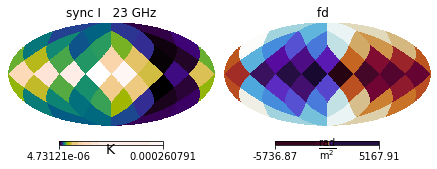

In [7]:
mock_data = img_obs.Measurements(sync_dset, fd_dset)

mock_data.show()

## Assembling the pipeline

After preparing our mock data, we can proceed with the set up of the IMAGINE pipeline. First, we initialize the `Likelihood`, using the mock observational data

In [8]:
## Use an ensemble to estimate the galactic variance
likelihood = img.likelihoods.EnsembleLikelihood(mock_data)

Then, we prepare the `FieldFactory` list:

In [9]:
## WMAP B-field, vary only b0 and psi0
breg_factory = BregLSAFactory()
breg_factory.active_parameters = ('b0', 'psi0')
breg_factory.priors = {'b0':  img.priors.FlatPrior(xmin=0., xmax=10.), 
                      'psi0': img.priors.FlatPrior(xmin=0., xmax=50.)}
## Fixed CR model
cre_factory = CREAnaFactory()
## Fixed FE model
fereg_factory = TEregYMW16Factory()

# Final Field factory list
factory_list = [breg_factory, cre_factory, fereg_factory]

We initialize the `Simulator`, in this case: `Hammurabi` .

In [10]:
simulator = img.simulators.Hammurabi(measurements=mock_data)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


Finally, we initialize and setup the `Pipeline` itself, using the `Multinest` sampler.

In [11]:
# Assembles the pipeline using MultiNest as sampler
pipeline = img.pipelines.MultinestPipeline(run_directory='../runs/tutorial_example/',
                                           simulator=simulator, 
                                           show_progress_reports=True,
                                           factory_list=factory_list, 
                                           likelihood=likelihood, 
                                           ensemble_size=1, n_evals_report=15)
pipeline.sampling_controllers = {'n_live_points': 500}

We set a run directory, `'runs/tutorial_example'` for storing this state of the run and MultiNest's chains. This is *strongly recommended*, as it makes it easier to resume a crashed or interrupted IMAGINE run.

Since there are no stochastic fields in this model, we chose an ensemble size of 1.

## Checking the setup

Before running a heavy job, it is a good idea to be able to roughly estimate how long it will take (so that one can e.g. decide whether one will read emails, prepare some coffee, or take a week of holidays while waiting for the results).

One thing that can be done is checking how long the code takes to do an individual likelihood function evaluation (note that each of these include the whole ensemble). This can be done using the `test()` method, which allows
one to test the `Pipeline` object evaluating a few times the final likelihood function (which is handed to the sampler in an actual run) and timing it.

In [12]:
pipeline.test(n_points=4);

Sampling centres of the parameter ranges.
	Evaluating point: [5.0, 25.0]
	Log-likelihood -63230233.62965755
	Total execution time:  3.699134146794677 s

Randomly sampling from prior.
	Evaluating point: [3.02332573 7.33779454]
	Log-likelihood -2440296.9511515824
	Total execution time:  3.7439119834452868 s

Randomly sampling from prior.
	Evaluating point: [0.92338595 9.31301057]
	Log-likelihood -56235239.046620436
	Total execution time:  3.723511670716107 s

Randomly sampling from prior.
	Evaluating point: [ 3.45560727 19.83837371]
	Log-likelihood -5868446.043333106
	Total execution time:  3.6879931911826134 s

Average execution time: 3.713637748034671 s


This is not a small amount of time.  Note that thousands of evaluations will be needed to be able to estimate the evidence (and/or posterior distributions). 
Fortunately, this tutorial comes with the results from an interrupted run, reducing the amount of waiting in case someone is interested in seeing the pipeline in action.

## Running on a jupyter notebook

While running the pipeline in a jupyter notebook, a simple progress report is generated every `pipeline.n_evals_report` evaluations of the likelihood. In the nested sampling case, this shows the parameter choices for rejected ("dead") points  as a function of log "prior volume", $\ln X$, and the distributions of both rejected points and "live" points (the latter in red).

One may allow the pipeline to run (for many hours) to completion or simply skip the next cell.  The last section of this tutorial *loads* a completed version this very same pipeline from disk, if one is curious about how the results look like.


**Progress report:**
number of likelihood evaluations  4500

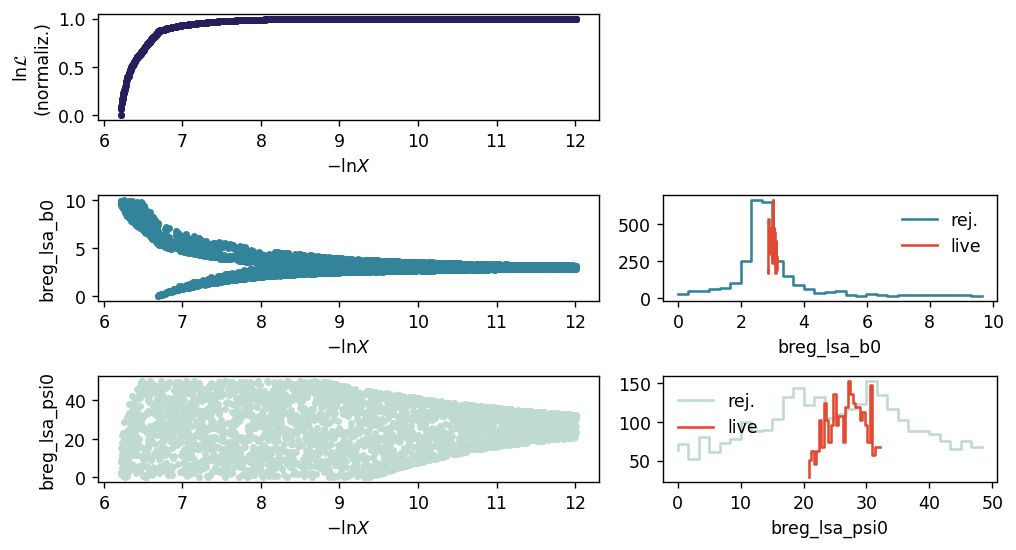

In [ ]:
results=pipeline()

## Monitoring progress when running as a script

When IMAGINE is launched using a script (e.g. when running on a cluster) it is still possible to monitor the progress by inspecting the file `progress_report.pdf` in the selected run directory. 

## Saving and loading

The `pipeline` is automatically saved to the specified `run_directory` immediately before and immediately after running the sampler. It can also be saved, at any time, using the `pipeline.save()`.

Being able to save and load IMAGINE Pipelines is particularly convenient if one has to 
alternate between a workstation and an HPC cluster: one can start preparing the setup on the workstation, using a jupyter notebook; then submit a script to the cluster which runs the previously saved pipeline; then reopen the pipeline on a jupyter notebook to inspect the results.

To illustrate these tools, let us load a completed version of the above example:

In [14]:
previous_pipeline = img.load_pipeline('../runs/tutorial_example_completed/')

This object should contain (in its attributes) all the information one can need to run, manipulate or analise an IMAGINE pipeline. For example, one can inspect which field factories were used in this run

In [15]:
print('Field factories used: ', end='')
for field_factory in previous_pipeline.factory_list:
    print(field_factory.name, end=', ')

Field factories used: breg_lsa, cre_ana, tereg_ymw16, 

Or, perhaps one may be interested in finding which simulator was used

In [16]:
previous_pipeline.simulator

The previously selected observational data can be accessed inspecting the Likelihood object which was supplied to the Pipeline:

In [17]:
print('The Measurements object keys are:')
print(list(previous_pipeline.likelihood.measurement_dict.keys()))

The Measurements object keys are:
[('sync', 23, 2, 'I'), ('fd', None, 2, None)]


And one can, of course, also *run the pipeline*

  analysing data from ../runs/tutorial_example_completed/chains/multinest_.txt



**Posterior report:**

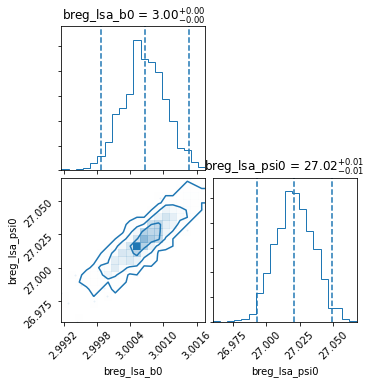

<IPython.core.display.Math object>

**Evidence report:**

<IPython.core.display.Math object>

In [18]:
previous_pipeline(save_pipeline_state=False);

## Best-fit model

Frequently, it is useful (or needed) to inspect (or re-use) the best-fit choice of parameters found. For covenience, this can be done using the property `pipeline.median_model`, which generates a list of Fields corresponding to the median values of all the paramters varied in the inference.

In [19]:
# Reads the list of Fields corresponding the best-fit model
best_fit_fields_list = previous_pipeline.median_model

# Prints Field name and parameter choices 
# (NB this combines default and active parameters)
for field in best_fit_fields_list:
    print('\n',field.name)
    for p, v in field.parameters.items():
        print('\t',p,'\t',v)


 breg_lsa
	 b0 	 3.0006600127943743
	 psi0 	 27.020995955659178
	 psi1 	 0.9
	 chi0 	 25.0

 cre_ana
	 alpha 	 3.0
	 beta 	 0.0
	 theta 	 0.0
	 r0 	 5.0
	 z0 	 1.0
	 E0 	 20.6
	 j0 	 0.0217

 tereg_ymw16


This list of Fields can, then, be directly used as argument by any compatible Simulator object. 

Often, however, one is interested in inspecting the Simulation associated with the best-fit model under
the exact same conditions (including random seeds for stochastic components) used in the original pipeline run.
For this, we can use the `median_simulation` Pipeline property.

In [20]:
simulated_maps = previous_pipeline.median_simulation

This allows us to *visually inspect* the outcomes of the run, comparing them to the original observational data
(or mock data, in the case of this tutorial), and spot any larger issues.

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


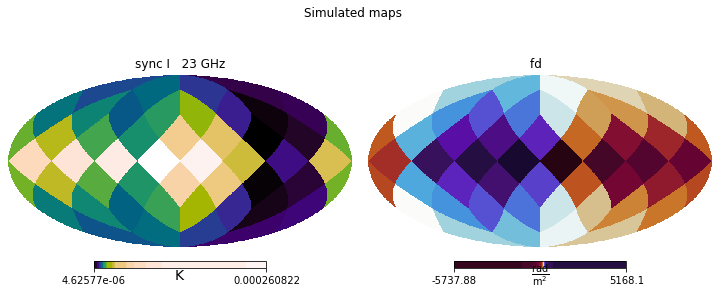

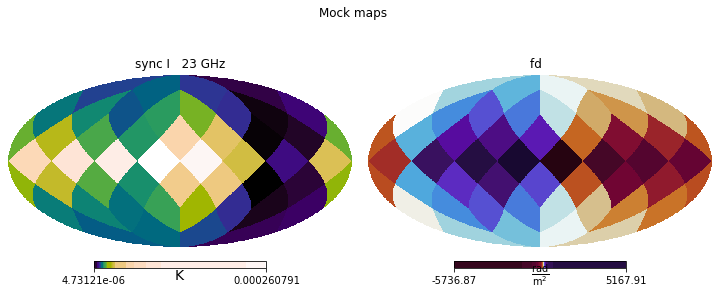

In [21]:
plt.figure(figsize=(10,4))
simulated_maps.show()
plt.suptitle('Simulated maps')
plt.figure(figsize=(10,4))
plt.suptitle('Mock maps')
mock_data.show()